From [02_currency_choice.ipynb](02_currency_choice.ipynb) we have found that ('ETH/USDT', 'BCH/USDT') is a valid candidate for our strategy.

In [2]:
import ccxt
import pandas as pd

def fetch_ohlcv(exchange_name: str,
                symbol: str,
                since: int = None,
                limit: int = 1000) -> pd.DataFrame:
    exchange = getattr(ccxt, exchange_name)()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe='1d', since=since, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp','open','high','low','close','volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    return df[['open','high','low','close','volume']]

def get_pair_data(exchange_name: str,
                  symbol_a: str,
                  symbol_b: str,
                  since: int = None,
                  limit: int = 1000) -> pd.DataFrame:
    df_a = fetch_ohlcv(exchange_name, symbol_a, since, limit)
    df_b = fetch_ohlcv(exchange_name, symbol_b, since, limit)

    # align on datetime and take only the closing prices
    df = pd.concat([
        df_a['close'].rename(symbol_a),
        df_b['close'].rename(symbol_b)
    ], axis=1).dropna()

    return df

In [62]:
symbol_a = 'XRP/USDT'
symbol_b = 'XLM/USDT'

In [63]:
data = get_pair_data('binance', symbol_a, symbol_b, limit=1000)
data.head()

,XRP/USDT,XLM/USDT
datetime,,
2022-10-30,0.4582,0.1112
2022-10-31,0.4641,0.1113
2022-11-01,0.4636,0.1099
2022-11-02,0.4497,0.1075
2022-11-03,0.4548,0.1088


In [64]:
rolling_window = 60
entry_threshold = 2.0
exit_threshold = 0.5

In [65]:
import statsmodels.api as sm
y = data[symbol_a]
X = sm.add_constant(data[symbol_b])

model = sm.OLS(y, X).fit()
residuals = model.resid

rolling_mean_res = residuals.rolling(window=rolling_window).mean()
rolling_std_res = residuals.rolling(window=rolling_window).std()
z_score = (residuals - rolling_mean_res) / rolling_std_res

In [66]:
data['long_entry'] = z_score < -entry_threshold
data['short_entry'] = z_score > entry_threshold
data['exit'] = z_score.abs() < exit_threshold

In [67]:
data['long_entry'].sum()

np.int64(68)

In [68]:
data['exit'].sum()

np.int64(204)

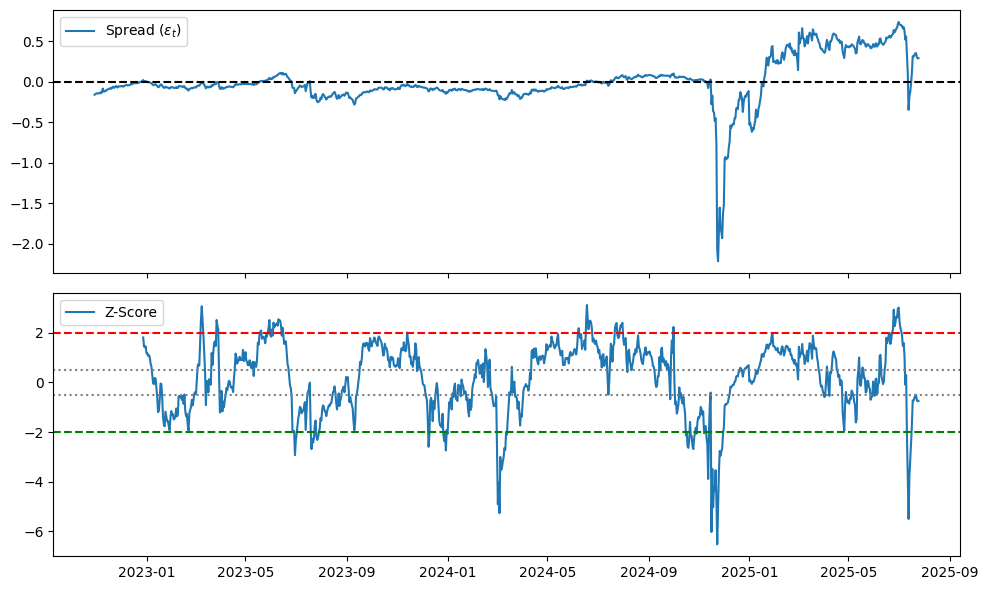

In [69]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(data.index, residuals, label=r'Spread ($\epsilon_t$)')
axes[0].axhline(0, color='black', linestyle='--')
axes[0].legend()

axes[1].plot(data.index, z_score, label='Z-Score')
axes[1].axhline(entry_threshold, color='red', linestyle='--')
axes[1].axhline(-entry_threshold, color='green', linestyle='--')
axes[1].axhline(exit_threshold, color='grey', linestyle=':')
axes[1].axhline(-exit_threshold, color='grey', linestyle=':')
axes[1].legend()

plt.tight_layout()
plt.show()

The visuals look satisfying. Now we can backtest the strategy in [04_backtest.ipynb](04_backtest.ipynb).